In [1]:
import imp
import pandas as pd
import geopandas as gpd
import numpy as np
import nivapy3 as nivapy
import altair as alt
import datetime as dt
from bs4 import BeautifulSoup

# Load tenporary AM API
am_path = r'/home/jovyan/development/Aquamonitor-Python/aquamonitor.py'
am = imp.load_source('aquamonitor', am_path)

In [ ]:
am.host = "https://test-aquamonitor.niva.no/"
am.aqua_site = "admin/"

## 1. Login

In [ ]:
token = am.jhub_login()

## 2. Get all Labware "projects" for 1000 Lakes Survey

Note that a "project" in Labware is not the same as a "project" in AM.

In [ ]:
# Get Labware projects
proj_df = am.get_labware_projects(token, '190091;3')

proj_df.head()

## 3. Get all samples for projects 

In [ ]:
samp_df = am.get_labware_project_samples(token, proj_df['name'])

samp_df.head()

## 4. Get results for samples

In [ ]:
res_df = am.get_labware_sample_results(token, samp_df['sampleNumber'])

res_df.head()

## 5. Combine Labware data

In [ ]:
# Tidy
samp_df2 = samp_df[['sampleNumber', 'station_id', 'station_name', 
                    'station_type', 'sampledDate', 'sampleDepthUpper', 
                    'sampleDepthLower']]

samp_df2.columns = ['sample_id', 'station_id', 'station_name', 
                    'station_type', 'sample_date', 'depth1', 
                    'depth2']

res_df2 = res_df[['sample_id', 'name', 'status', 'loq', 'numericEntry', 'units']]
res_df2.columns = ['sample_id', 'parameter', 'status', 'loq', 'value', 'units']

# Join
lw_df = pd.merge(res_df2, samp_df2, how='left', on='sample_id')

# Add verbose status codes
res_status = pd.read_csv('labware_result_status_codes.csv', sep=';')
lw_df = pd.merge(lw_df, res_status, how='left', on='status')
del lw_df['status']
lw_df.rename({'description':'status'}, axis='columns', inplace=True)

# Tidy
lw_df = lw_df[['sample_id', 'station_id', 'station_name', 'station_type', 'sample_date', 
               'depth1', 'depth2', 'parameter', 'status', 'loq', 'value', 'units']]

# Get only surface samples
lw_df = lw_df.query('(depth1==0) and (depth2==0)')
del lw_df['depth1'], lw_df['depth2']

# Reclassify 'Nitrat' as 'Nitritt + nitrat'
lw_df['parameter'].replace({'Nitrat':'Nitritt + nitrat'}, inplace=True)

# Add verbose status codes
res_status = pd.read_csv('labware_result_status_codes.csv', sep=';')

# Drop duplicates
lw_df.drop_duplicates(inplace=True)

lw_df.head()

## 6. Get data from 1995

In [ ]:
# Download all data for project
excel_file = 'am1000sjoer.xlsx'
am.Query('project_id=' + str(12433), token).makeArchive('excel', excel_file).download('')

In [ ]:
# Read downloaded data
chem_df = pd.read_excel(excel_file, 
                        sheet_name='WaterChemistry',
                        header=[0,1],
                       )
chem_df.columns = chem_df.columns.map('_'.join)
chem_df.columns = [i.split('_')[-1] if i[:7] == 'Unnamed' else i for i in chem_df.columns]

# Parse dates, filter to 1995 and tidy
chem_df['SampleDate'] = pd.to_datetime(chem_df['SampleDate'], format='%d.%m.%Y %H.%M.%S')
chem_df = chem_df[chem_df['SampleDate'].dt.year == 1995]
chem_df.drop(['ProjectId', 'ProjectName', 'StationCode', 'StationName', 'SampleDate'], axis=1, inplace=True)

# Restructure
chem_df = chem_df.melt(id_vars=['StationId', 'Depth1', 'Depth2'],
                       var_name='par_unit')

# AM export seems to mix '.' and ',' as the decimal separator
chem_df['value'] = chem_df['value'].astype(str).str.replace(',', '.')

# Convert LOD to value
chem_df['value'] = chem_df['value'].str.strip('<').astype(float)

# Average duplicates
chem_df = chem_df.groupby(['StationId', 'Depth1', 'Depth2', 'par_unit']).mean().reset_index()

chem_df['parameter'], chem_df['units'] = chem_df['par_unit'].str.split('_', 1).str
del chem_df['par_unit']

# Tidy
chem_df = chem_df[['StationId', 'Depth1', 'Depth2', 'parameter', 'value', 'units']]
chem_df.columns = ['station_id', 'depth1', 'depth2', 'parameter', 'value', 'units']
chem_df.dropna(how='any', inplace=True)

# Get only surface samples
chem_df = chem_df.query('(depth1==0) and (depth2==0)')
del chem_df['depth1'], chem_df['depth2']

# Link labware param names
par_map = pd.read_csv('am_labware_par_map.csv', sep=';')

chem_df = pd.merge(chem_df, par_map, how='left',
                   left_on='parameter', right_on='am_parameter')

# Convert units
chem_df['value'] = chem_df['value'] * chem_df['factor']

# Only keep values that can be matched in Labware
del chem_df['parameter'], chem_df['am_parameter'], chem_df['factor'], chem_df['units']
chem_df.dropna(subset=['labware_parameter'], inplace=True)

chem_df.rename({'labware_parameter':'parameter'}, axis='columns', inplace=True)

chem_df.head()

## 7. Link 1995 and 2019 datasets

In [ ]:
# Combine
df = pd.merge(lw_df, chem_df, how='left', on=['station_id', 'parameter'],
              suffixes=['_lw', '_am'])

df.dropna(subset=['value_am', 'value_lw'], inplace=True)

df.head()

## Additional filtering and processing requested by Atle

 * **Added 25.11.2019:** Remove Åsmundvatnet as sample is obviously contaminated and it skews the plots. After some checking by Atle, it seems this site is brackish/estuarine.

In [ ]:
df = df.query('station_name != "Åsmundvatnet"')

 * **Added 07.01.2019:** Include Ca/Mg ratios for "Authorised" values.

In [ ]:
df_list = []

for src in ['lw', 'am']:
    # Get authorised Ca and Mg data
    df2 = df[['sample_id', 'parameter', 'status', f'value_{src}']]
    df2 = df2.query("(parameter in ('Kalsium', 'Magnesium')) and (status == 'Authorised')")
    del df2['status']
    
    # Restructure
    df2.set_index(['sample_id', 'parameter'], inplace=True)
    df2 = df2.unstack('parameter')
    df2.columns = ['Kalsium', 'Magnesium']
    
    # Calc Ca/Mg ratio
    df2[f'value_{src}'] = df2['Kalsium'] / df2['Magnesium']
    del df2['Kalsium'], df2['Magnesium']
    
    df_list.append(df2)

# Concatenate
df2 = pd.concat(df_list, axis=1)
df2['parameter'] = 'Ca/Mg'
df2['status'] = 'Authorised'
df2['units'] = 'None'
df2.reset_index(inplace=True)

# Join metadata
df3 = df[['sample_id', 'station_id', 'station_name', 'station_type', 'sample_date']].copy()
df3.drop_duplicates(subset=['sample_id'], inplace=True)
df2 = pd.merge(df2, df3, how='left', on='sample_id')

# Add to main df
df = pd.concat([df, df2], axis=0, sort=False)

In [ ]:
# Save data
df.to_csv('1000_lakes_lw_am.csv', index=False, encoding='utf-8')

## 8. Build data visualisation

In [2]:
# Read data for speed
df = pd.read_csv('1000_lakes_lw_am.csv')
df = df.query('value_am > 0')
df.head()

,sample_id,station_id,station_name,station_type,sample_date,parameter,status,loq,value_lw,units,value_am
0,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Bly,Entered,"0,01",0.68,UG_P_L,0.660
1,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Aluminium,Entered,1,390.00,UG_P_L,24.000
2,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Arsen,Entered,"0,02",0.33,UG_P_L,0.357
3,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Kobber,Entered,"0,05",1.10,UG_P_L,1.000
4,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Krom,Entered,"0,05",0.46,UG_P_L,0.400


In [3]:
# Read station co-ords
stn_df = pd.read_excel('am1000sjoer.xlsx', sheet_name='StationPoint')
stn_df = stn_df[['StationId', 'Latitude', 'Longitude']]
stn_df.columns = ['station_id', 'lat', 'lon']

df = pd.merge(df, stn_df, how='left', on='station_id')

# Calc ratio 2019:1995
df['ratio_2019:1995'] = df['value_lw'] / df['value_am']
df['log(ratio_2019:1995)'] = np.log10(df['ratio_2019:1995'])

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
# Get Norway coastline
fylker_path = '/home/jovyan/dstoolkit_examples/data/gis/vector/fylker.geojson'
gdf = gpd.read_file(fylker_path)

# Dissolve to single polygon
gdf['dissolvefield'] = 1
gdf = gdf.dissolve(by='dissolvefield')

# Build Altair dataset
nor  = alt.InlineData(values = gdf.to_json(), #geopandas to geojson string
                       # root object type is "FeatureCollection" but we need its features
                       format = alt.DataFormat(property='features',type='json')) 

* **Updated 06.01.2020** to share x and y scales for histograms. This gives some slightly odd-looking x-scales for some parameters with large outliers

* **Updated 07.01.2020** to include the map

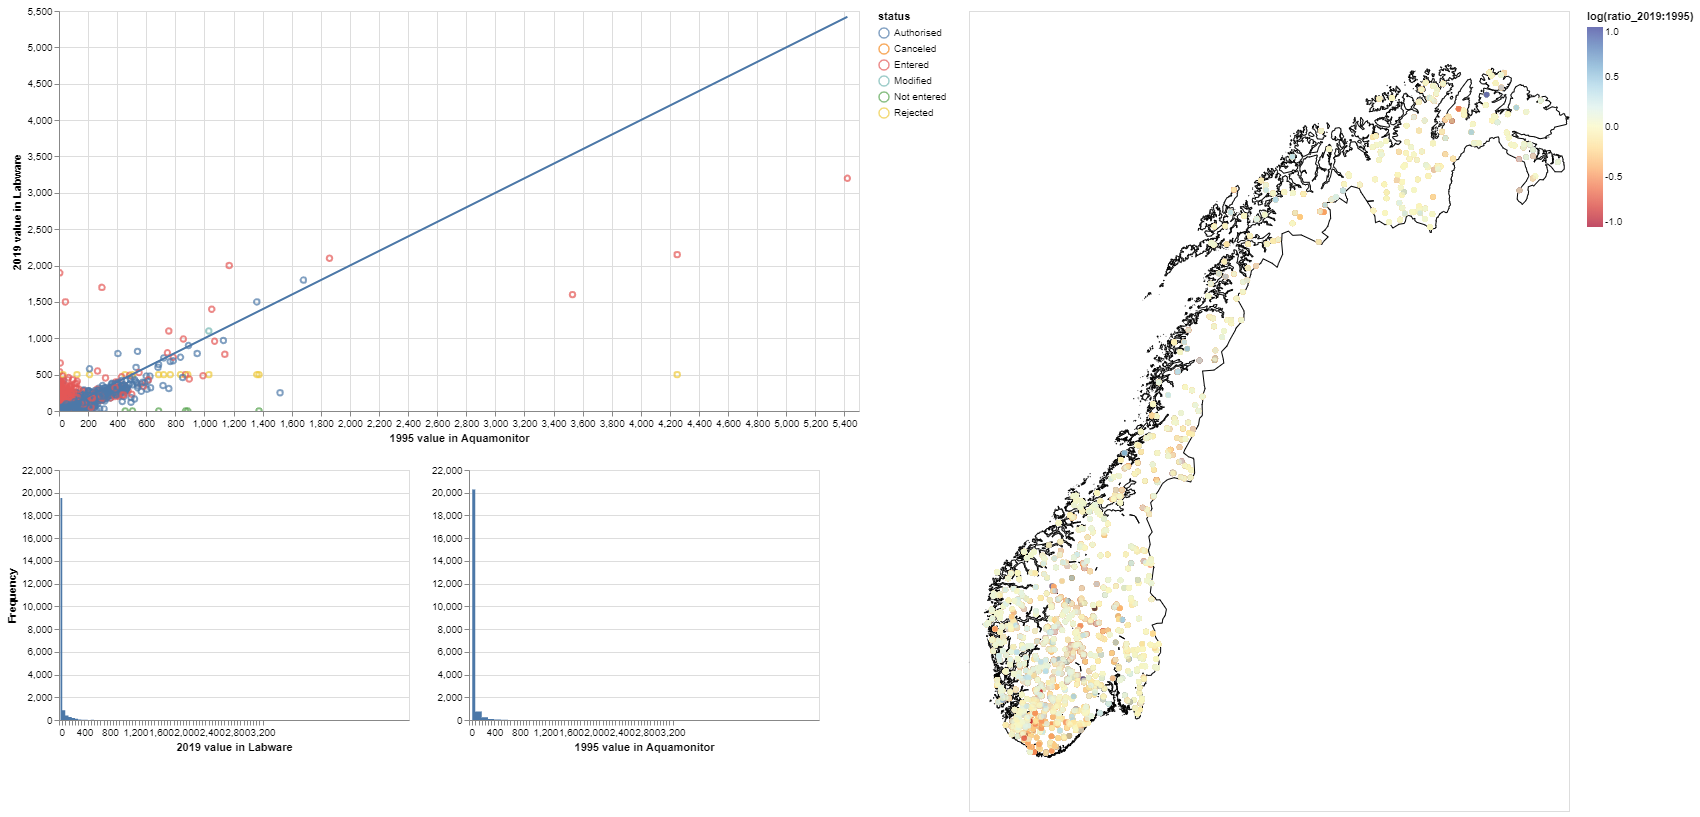

In [5]:
# Save data as JSON
alt.data_transformers.enable('json')

# Build drop-down list
par_list = ['None'] + sorted(df['parameter'].unique())
input_dropdown = alt.binding_select(options=par_list)
selection = alt.selection_single(fields=['parameter'], bind=input_dropdown, name='Select')

# Scatter plot
scatter = alt.Chart(df, height=400, width=800).mark_point().encode(
    x=alt.X('value_am:Q', title='1995 value in Aquamonitor'),
    y=alt.Y('value_lw:Q', title='2019 value in Labware'),
    tooltip=['station_id:N', 'station_name:N', 'sample_date:T', 'status:N', 'ratio_2019:1995:Q', 'log(ratio_2019:1995):Q'],
    color='status:N',
).add_selection(
    selection
).transform_filter(
    selection
).interactive()

# 1:1 line
line = alt.Chart(df, height=400, width=800).mark_line().encode(
    x=alt.X('value_am:Q', title=''),
    y=alt.Y('value_am:Q', title=''),
).transform_filter(
    selection
)

# Labware histogram
lw_hist = alt.Chart(df, height=250, width=350).mark_area(
    interpolate='step'
).encode(
    x=alt.X("value_lw:Q", bin=alt.Bin(maxbins=100), title='2019 value in Labware'),
    y=alt.Y('count()', title='Frequency'),
).transform_filter(
    selection
)

# AM histogram
am_hist = alt.Chart(df, height=250, width=350).mark_area(
    interpolate='step'
).encode(
    x=alt.X("value_am:Q", bin=alt.Bin(maxbins=100), title='1995 value in Aquamonitor'),
    y=alt.Y('count()', title=''),
).transform_filter(
    selection
)

hists = alt.hconcat(
    lw_hist,
    am_hist,
).resolve_scale(y='shared',
                x='shared',
)

# Basemap
basemap = alt.Chart(nor).mark_geoshape(
    stroke='black'
).encode(
    color=alt.value('white'),
).properties(
    width=600,
    height=800
)

# Plot locations
locs = alt.Chart(df).mark_circle().encode(
    longitude=alt.X('lon:Q', title=''),
    latitude=alt.Y('lat:Q', title=''),
    tooltip=['station_id:N', 'station_name:N', 'sample_date:T', 'status:N', 'ratio_2019:1995:Q', 'log(ratio_2019:1995):Q'],
    color=alt.Color('log(ratio_2019:1995)', scale=alt.Scale(scheme='redyellowblue', domain=[-1, 1])),
).add_selection(
    selection
).transform_filter(
    selection
)

# Layout
chart = ((scatter + line) & hists) | (basemap + locs)
chart.save('qc_1000_lakes.json')

chart

## 9. Update `index.html`

In [6]:
# Build new text
today = dt.datetime.today()
today = today.strftime('%d.%m.%Y')
new_text = f'Labware results were last updated {today}'

# Update HTML. See https://stackoverflow.com/a/42882971/505698
soup = BeautifulSoup(open('index.html'), 'html.parser')
h3 = soup.find('h3')
h3.string.replace_with(new_text)

with open('index.html', 'w') as file:
    file.write(str(soup))

## 10. Parameter status by station

See e-mail from Atle received 27.11.2019 at 16.24.

In [7]:
par_status_df = lw_df[['parameter', 'station_id', 'status']].drop_duplicates().groupby(['parameter', 'status']).count().sort_index().reset_index()
par_status_df.columns = ['parameter', 'status', 'sample_count']

par_status_df.to_csv('par_status_by_station.csv', index=False, encoding='utf-8')

NameError: name 'lw_df' is not defined